In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime
import seaborn as sns

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


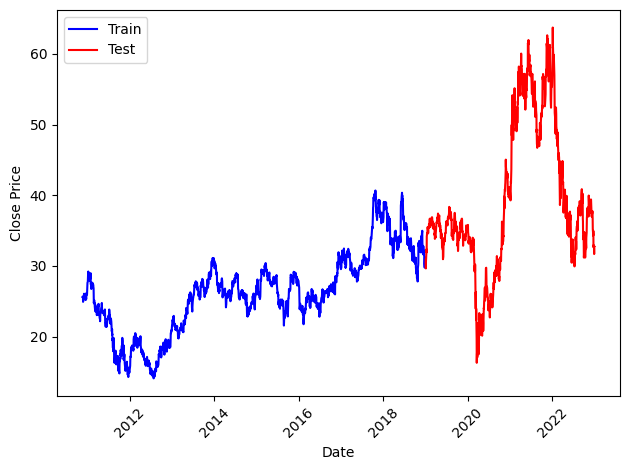

In [2]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
data = Data('GM',start_date,end_date,period,2019)
data.data_preprocess()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter ranges (adjust based on your domain knowledge)
crossover_rates = [0.6, 0.8, 0.95]
mutation_rates = [0.01, 0.1, 0.3]
inversion_rates = [0.01, 0.05, 0.1]  # assuming inversion is another operator you tune

num_runs = 10 # number of independent runs per config

# Store results
results = []

for r_cross in crossover_rates:
    for r_mut in mutation_rates:
        for r_inv in inversion_rates:
            for run in range(num_runs):
                ga = IslandGGA(
                    data=data.train_data,
                    K=4,
                    num_islands=10,
                    m_iter=5,
                    num_iter=50,
                    pSize=100,
                    r_cross=r_cross,
                    r_mut=r_mut,
                    r_inv=r_inv,  # make sure your IslandGGA accepts this param
                    strategies=data.strategies,
                    evolve_strategy='ring'  # or whichever you want to test here
                )
                ga.evolve()
                final_score = ga.convergence_times[-1]  # or use an evaluation function
                
                results.append({
                    'r_cross': r_cross,
                    'r_mut': r_mut,
                    'r_inv': r_inv,
                    'run': run,
                    'final_score': final_score
                })

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results.to_csv("parameter_effect_analysis_ring.csv", index=False)


Running ring
Generation 1: Best fitness = 7.86797125485741  Average Fitness = 2.254544274789393
Generation 2: Best fitness = 7.86797125485741  Average Fitness = 2.769253241879657
Generation 3: Best fitness = 7.86797125485741  Average Fitness = 3.4182308594857425
Generation 4: Best fitness = 7.86797125485741  Average Fitness = 3.587502805611823
Generation 5: Best fitness = 7.86797125485741  Average Fitness = 4.0185240390077706
Island 0 Migration -Left island 9 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 3
Island 3 Migration -Left island 2 -Right island 4
Island 4 Migration -Left island 3 -Right island 5
Island 5 Migration -Left island 4 -Right island 6
Island 6 Migration -Left island 5 -Right island 7
Island 7 Migration -Left island 6 -Right island 8
Island 8 Migration -Left island 7 -Right island 9
Island 9 Migration -Left island 8 -Right island 0
Generation 6: Best fitness = 7.86797125485741  Average Fitness = 3.910

In [4]:
summary = df_results.groupby(['r_cross', 'r_mut', 'r_inv']).agg(
    mean_score=('final_score', 'mean'),
    std_score=('final_score', 'std')
).reset_index()


In [9]:
# Step 1: Group by parameter combinations and compute mean and std
summary = df_results.groupby(['r_cross', 'r_mut', 'r_inv']).agg(
    mean_score=('final_score', 'mean'),
    std_score=('final_score', 'std')
).reset_index()

# Step 2: Sort and select top 5 configurations
top5 = summary.sort_values('mean_score', ascending=False).head(5).copy()
top5.head()

,r_cross,r_mut,r_inv,mean_score,std_score
20,0.95,0.01,0.10,11.259810,0.260835
12,0.80,0.10,0.00,11.236416,0.367533
24,0.95,0.30,0.00,11.032865,1.573734
18,0.95,0.01,0.00,11.003186,0.530178
16,0.80,0.30,0.05,10.926774,1.584257


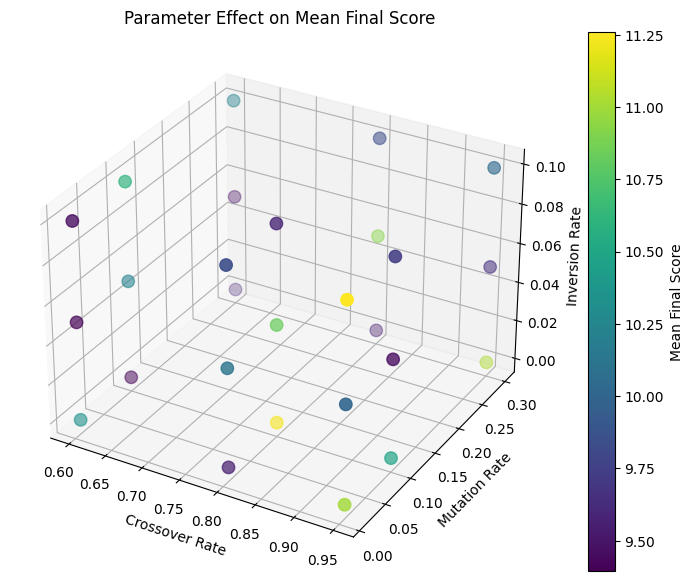

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot mean score for each parameter combo
ax.scatter(
    summary['r_cross'],
    summary['r_mut'],
    summary['r_inv'],
    c=summary['mean_score'],
    cmap='viridis',
    s=80
)

ax.set_xlabel("Crossover Rate")
ax.set_ylabel("Mutation Rate")
ax.set_zlabel("Inversion Rate")
fig.colorbar(ax.collections[0], ax=ax, label='Mean Final Score')

plt.title("Parameter Effect on Mean Final Score")
plt.show()


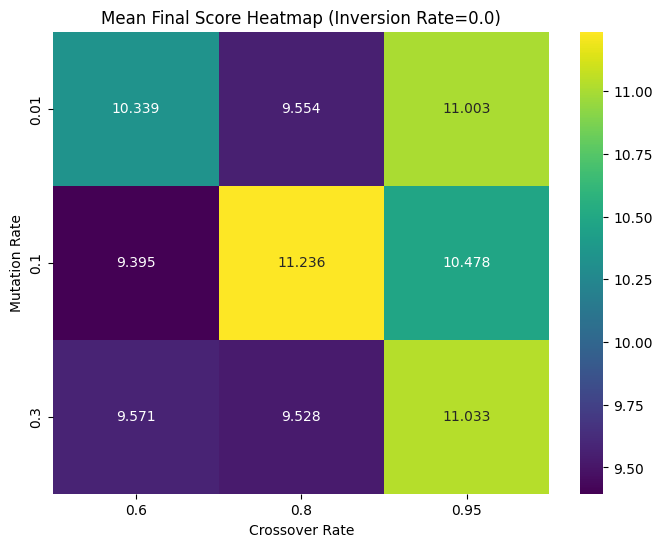

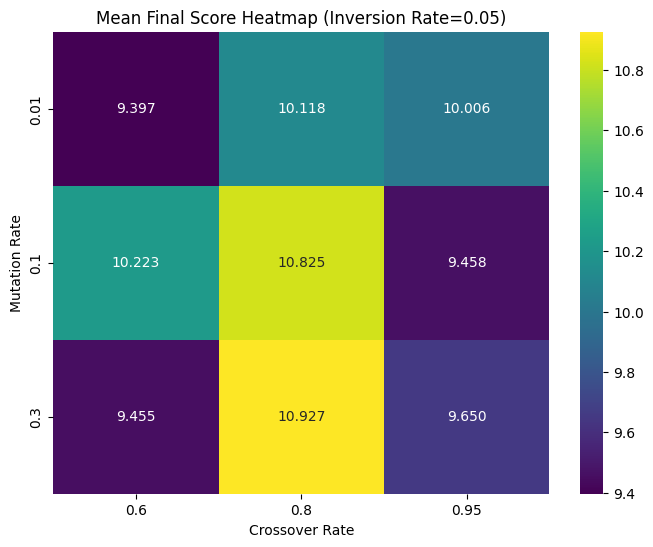

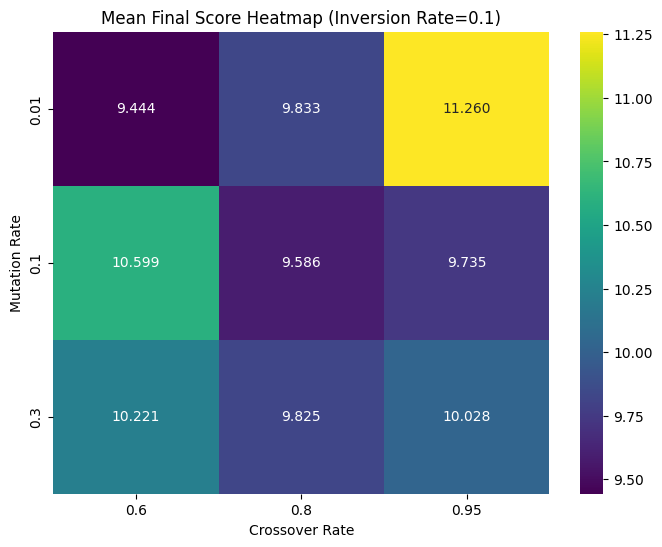

In [5]:
# Example: visualize heatmaps for each inversion rate value

for r_inv_val in inversion_rates:
    pivot = summary[summary['r_inv'] == r_inv_val].pivot(
        index='r_mut', columns='r_cross', values='mean_score'
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
    plt.title(f"Mean Final Score Heatmap (Inversion Rate={r_inv_val})")
    plt.xlabel("Crossover Rate")
    plt.ylabel("Mutation Rate")
    plt.show()


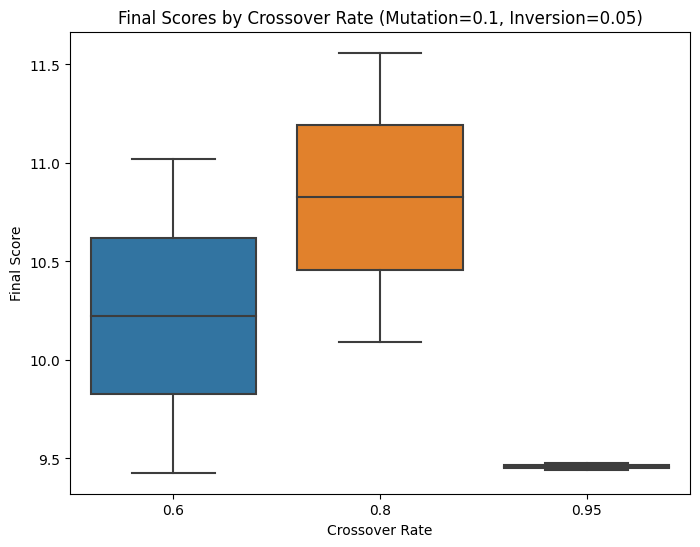

In [6]:
# Example: boxplot of final scores grouped by crossover rate at fixed mutation and inversion

fixed_mut = 0.1
fixed_inv = 0.05

subset = df_results[(df_results['r_mut'] == fixed_mut) & (df_results['r_inv'] == fixed_inv)]

plt.figure(figsize=(8, 6))
sns.boxplot(data=subset, x='r_cross', y='final_score')
plt.title(f"Final Scores by Crossover Rate (Mutation={fixed_mut}, Inversion={fixed_inv})")
plt.xlabel("Crossover Rate")
plt.ylabel("Final Score")
plt.show()
